# Pairs Trading- finding pairs based on Clustering

In this case study, we will use clustering methods to select pairs for a pairs trading
strategy.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Data Transformation](#3.2)  
* [5.Evaluate Algorithms and Models](#5)        
    * [5.1. k-Means Clustering](#5.1)
        * [5.1.1 Finding right number of clusters](#5.1.1)
        * [5.1.2 Clustering and Visualization](#5.1.2)
    * [5.2. Hierarchial Clustering (Agglomerative Clustering)](#5.2)
        * [5.2.1. Building Hierarchy Graph/ Dendogram](#5.2.1)
        * [5.2.2. Clustering and Visualization](#5.2.1)
    * [5.3. Affinity Propagation Clustering](#5.3)
        * [5.3.1 Visualising the cluster](#5.2.1)
    * [5.4. Cluster Evaluation](#5.4)        
* [6.Pair Selection](#6)        
    * [6.1 Cointegration and Pair Selection Function](#6.1)    
    * [6.2. Pair Visualization](#6.2)     

<a id='0'></a>
# 1. Problem Definition

Our goal in this case study is to perform clustering analysis on the stocks of S&P500
and come up with pairs for a pairs trading strategy.


The data of the stocks of S&P 500, obtained using pandas_datareader from yahoo
finance. It includes price data from 2018 onwards.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas_datareader as dr

#Import Model Packages
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle

<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
#The data already obtained from yahoo finance is imported.
dataset = read_csv('SP500Data.csv',index_col=0)

In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
# shape
dataset.shape

(1768, 502)

In [7]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,54.426796,52.048283,72.345779,138.659592,177.699997,10.98,8.634363,37.271656,64.180237,139.873764,...,20.753773,133.155411,103.400002,151.862900,38.650249,62.594769,71.868057,103.709999,114.007050,68.286865
2018-01-03,54.754086,52.163368,73.477905,139.299545,181.039993,11.55,8.626429,37.381805,65.813210,140.634369,...,21.326937,135.646637,105.169998,150.217636,38.391579,63.357979,71.806381,105.769997,114.797356,68.600830
2018-01-04,55.010605,52.074833,73.058868,140.949005,183.220001,12.12,8.594687,37.767361,65.319534,141.175262,...,21.693485,137.023514,109.250000,151.030975,38.092442,63.780983,72.537415,107.860001,114.631943,69.009987
2018-01-05,55.718266,52.225346,74.330681,142.111664,185.339996,11.88,8.626429,38.017338,66.363876,142.358383,...,21.633505,137.902237,109.320000,152.038513,37.825672,63.661438,72.960182,109.540001,115.771454,69.799721
2018-01-08,55.983631,52.074833,73.139732,143.247375,185.039993,12.28,8.626429,38.114788,66.506294,142.510513,...,21.713484,137.159470,109.940002,150.014252,38.108608,63.891338,73.083481,110.629997,115.992027,70.636978


In [8]:
# describe data
set_option('display.precision', 3)
dataset.describe()

,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
count,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,...,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000,1768.000
mean,58.926,93.325,108.891,247.202,411.168,80.948,17.197,56.032,108.876,227.958,...,25.109,204.412,201.692,102.153,55.448,92.672,105.894,297.658,121.116,146.999
std,13.787,20.699,40.292,73.958,127.350,47.480,4.682,20.218,31.994,51.303,...,9.619,43.504,47.580,27.259,8.960,22.895,21.055,119.643,15.450,39.627
min,31.921,50.055,50.093,122.654,177.700,9.530,8.074,22.487,58.177,128.465,...,7.064,123.653,103.400,42.222,34.309,53.535,51.728,103.710,75.287,68.151
25%,47.033,76.468,71.980,173.268,288.480,33.022,13.365,40.434,74.028,194.861,...,17.791,175.781,163.475,83.819,51.743,72.440,87.968,206.308,109.203,117.051
50%,57.514,100.526,98.330,262.395,420.450,82.130,17.107,50.025,118.093,239.389,...,21.578,201.223,203.540,98.915,57.262,89.866,108.398,273.215,118.648,156.905
75%,68.248,109.922,141.409,307.932,509.515,111.705,21.212,66.993,134.964,267.371,...,30.296,230.592,237.922,116.204,61.842,110.843,124.854,360.580,130.027,176.812
max,91.225,133.728,203.870,397.037,688.370,211.380,27.223,114.741,175.156,333.572,...,59.226,331.596,307.210,186.823,72.321,144.778,141.099,614.550,168.359,240.631


<a id='2.2'></a>
## 3.2. Data Visualization

We will take a detailed look into the visualization post clustering.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [9]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Getting rid of the columns with more than 30% missing values.

In [10]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1768, 489)

Given that there are null values drop the rown contianing the null values.

In [11]:
# Fill the missing values with the last value available in the dataset.
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,54.427,52.048,72.346,138.66,177.70,10.98,8.634,37.272,64.180,139.874,...,20.754,133.155,103.40,151.863,38.650,62.595,71.868,103.71,114.007,68.287
2018-01-03,54.754,52.163,73.478,139.30,181.04,11.55,8.626,37.382,65.813,140.634,...,21.327,135.647,105.17,150.218,38.392,63.358,71.806,105.77,114.797,68.601


<a id='3.2'></a>
## 4.2. Data Transformation

For the purpose of clustering, we will be using annual
returns and variance as the variables as they are the indicators of the stock performance and its volatility. Let us prepare the return and volatility variables from the
data.

In [12]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns
#format the data as a numpy array to feed into the K-Means algorithm
#data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

All the variables should be on the same scale before applying clustering, otherwise a feature with large values will dominate the result. We use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

,Returns,Volatility
AOS,-0.824,-0.519
ABT,-0.184,-0.986


The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

<a id='4'></a>
# 5. Evaluate Algorithms and Models

We will look at the following models:

1. KMeans
2. Hierarchical Clustering (Agglomerative Clustering)
3. Affinity Propagation

<a id='5.1'></a>
## 5.1. K-Means Clustering


<a id='5.1.1'></a>
### 5.1.1. Finding optimal number of clusters

In this step we look at the following metrices:

1. Sum of square errors (SSE) within clusters
2. Silhouette score.

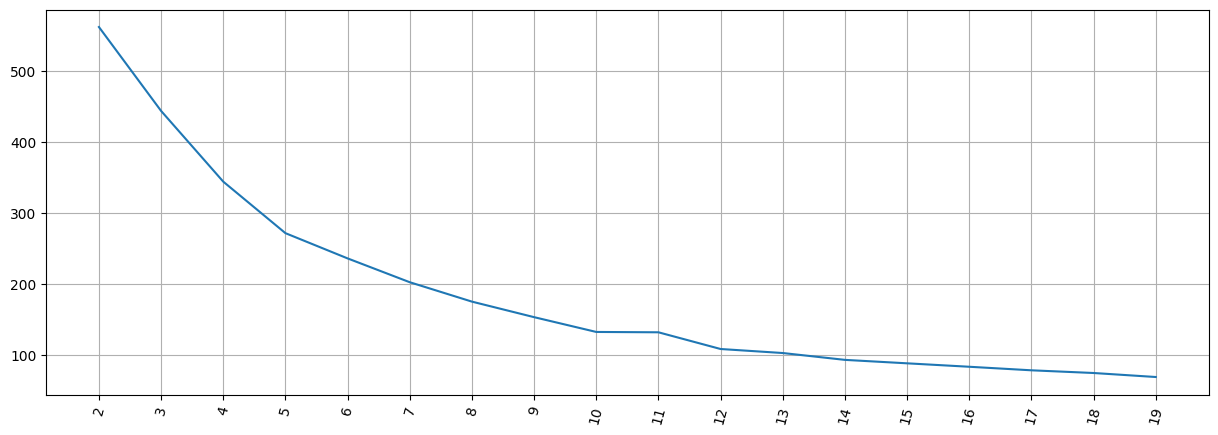

In [14]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

Inspecting the sum of squared errors chart, it appears the elbow “kink” occurs 5 or 6
clusters for this data. Certainly, we can see that as the number of clusters increase pass
6, the sum of square of errors within clusters plateaus off.

#### Silhouette score

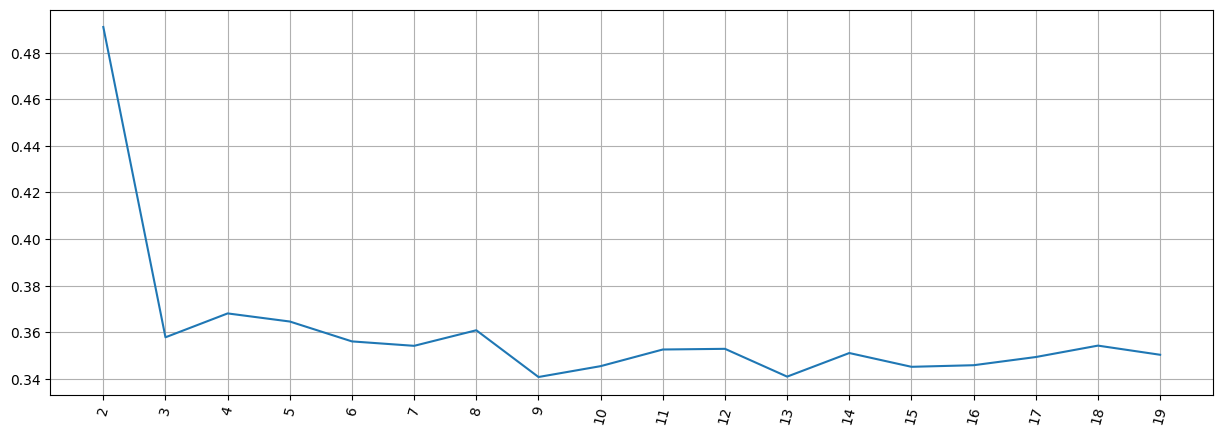

In [15]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

From the silhouette score chart, we can see that there are various parts of the graph
where a kink can be seen. Since there is not much a difference in SSE after 6 clusters,
we would prefer 6 clusters in the K-means model.

<a id='5.1.2'></a>
### 5.1.2.  Clustering and Visualisation

Let us build the k-means model with six clusters and
visualize the results.

In [16]:
nclust=6

In [17]:
#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=6)

In [18]:
#Extracting labels
target_labels = k_means.predict(X)

Visualizing how your clusters are formed is no easy task when the number of variables/dimensions in your dataset is very large. One of the methods of visualising a cluster in two-dimensional space.

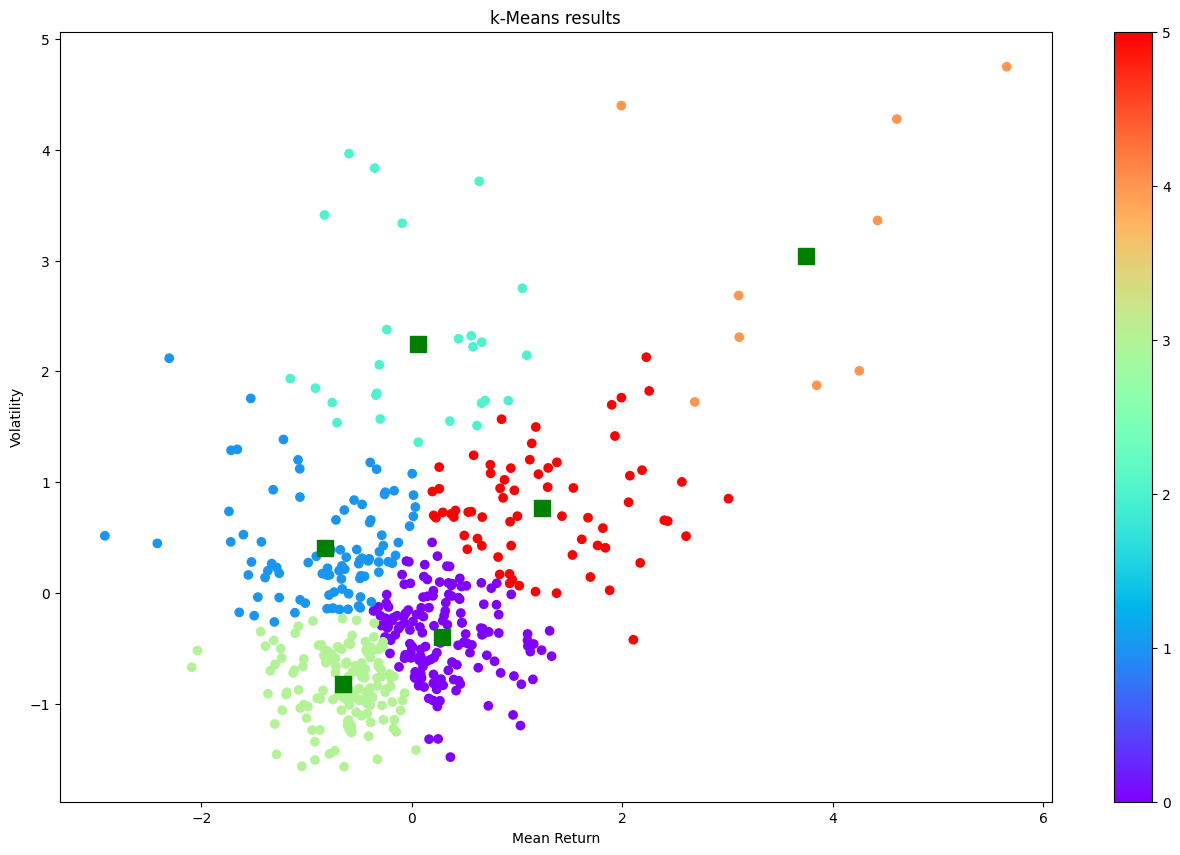

In [19]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

Let us check the elements of the clusters

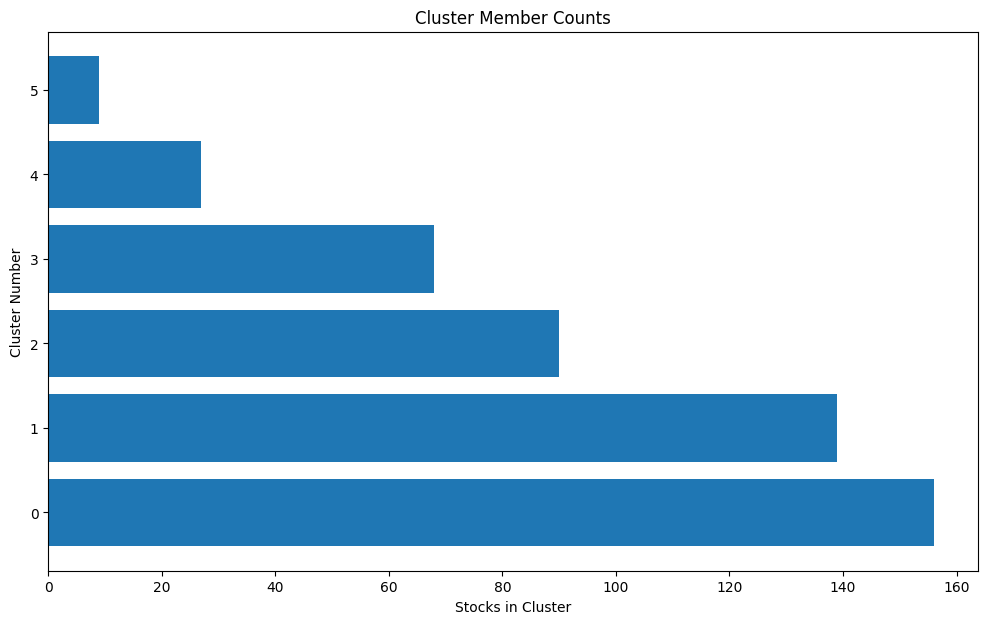

In [20]:
# show number of stocks in each cluster
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

The number of stocks in a cluster range from around 40 to 120. Although, the distribution is not equal, we have significant number of stocks in each cluster.

<a id='5.2'></a>
## 5.2. Hierarchical Clustering (Agglomerative Clustering)

In the first step we look at the hierarchy graph and check for the number of clusters

<a id='5.2.1'></a>
### 5.2.1. Building Hierarchy Graph/ Dendogram

The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters.

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

#Calulate linkage
Z= linkage(X, method='ward')
Z[0]

array([2.230000e+02, 2.860000e+02, 2.755536e-03, 2.000000e+00])

The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis, and thus the longer the branches are, the less correlated two clusters are.

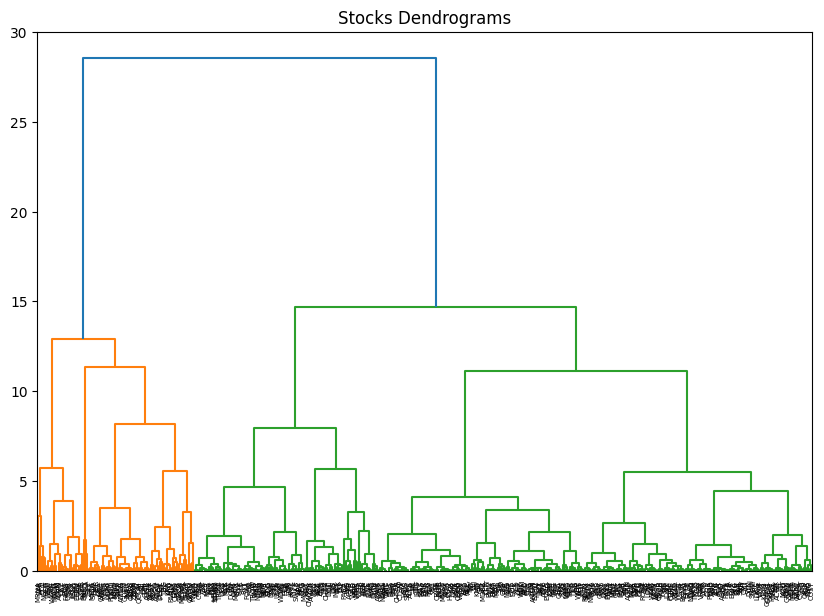

In [22]:
#Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
plt.show()

Once one big cluster is formed, the longest vertical distance without any horizontal line passing through it is selected and a horizontal line is drawn through it. The number of vertical lines this newly created horizontal line passes is equal to number of clusters.
Then we select the distance threshold to cut the dendrogram to obtain the selected clustering level. The output is the cluster labelled for each row of data. As expected from the dendrogram, a cut at 13 gives us four clusters.

In [23]:
distance_threshold = 13
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([3, 1, 2], dtype=int32)

<a id='5.2.2'></a>
### 5.2.2.  Clustering and Visualisation

In [24]:
nclust = 4
hc = AgglomerativeClustering(n_clusters=nclust, linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

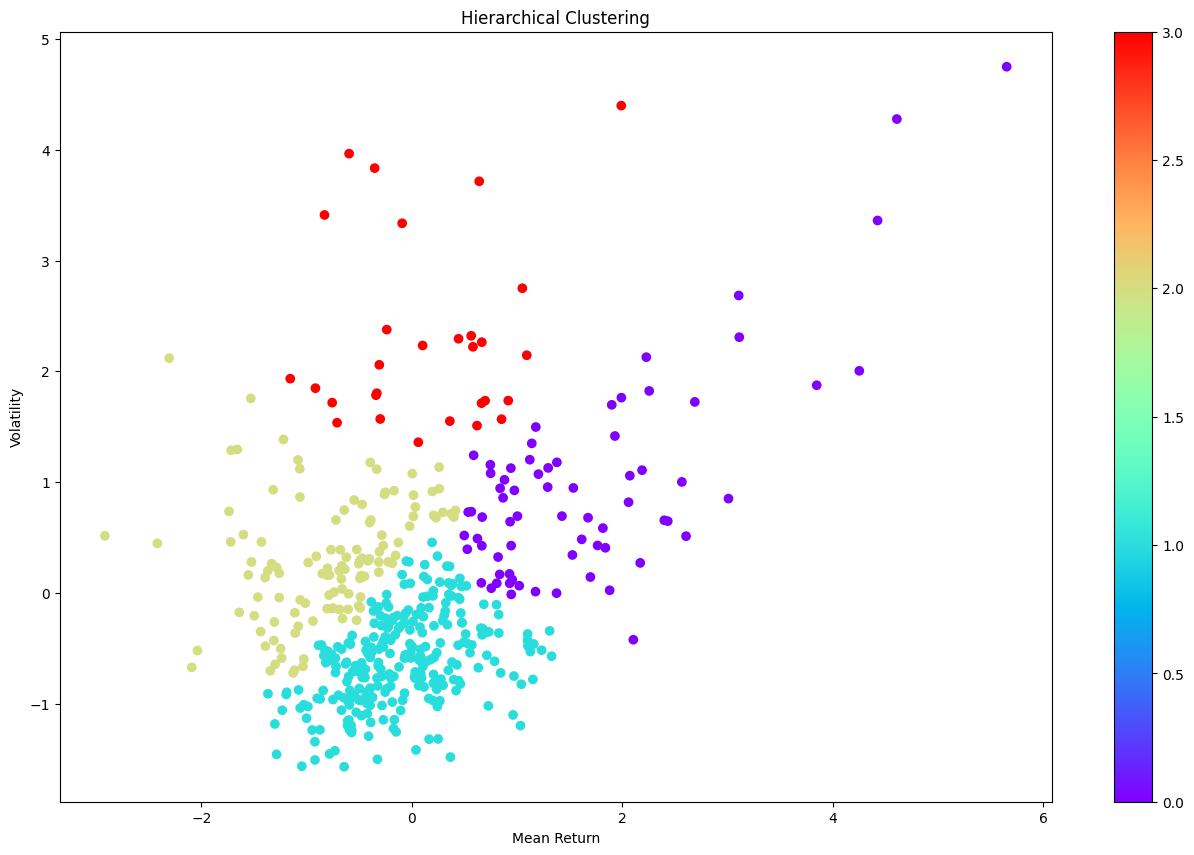

In [25]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

Similar to the plot of k-means clustering, we see that there are some distinct clusters
separated by different colors.

<a id='5.3'></a>
## 5.3. Affinity Propagation

In [26]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

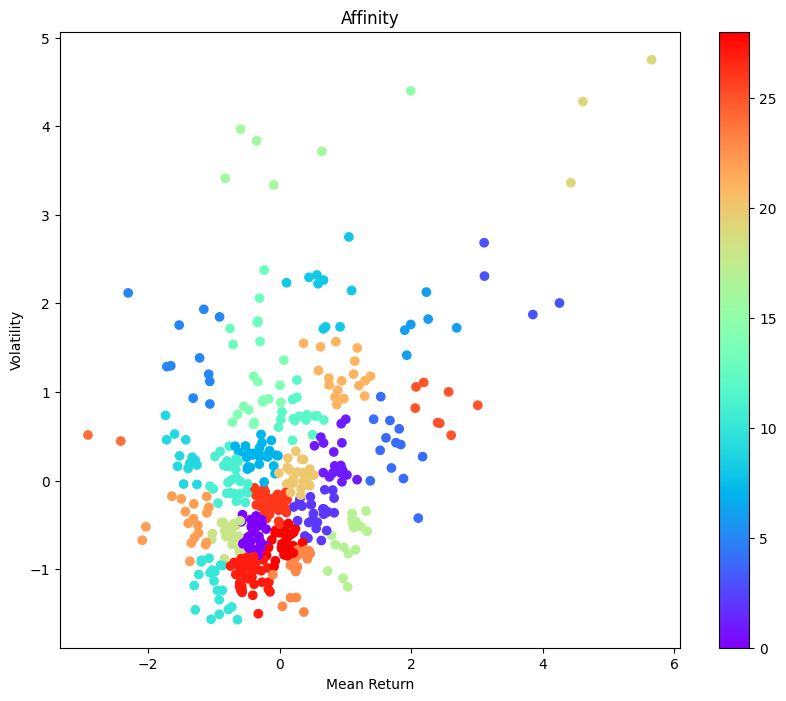

In [27]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

Similar to the plot of k-means clustering, we see that there are some distinct clusters separated by different colors.

<a id='5.3.1'></a>
### 5.3.1 Cluster Visualisation

In [28]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

Estimated number of clusters: 29


<Figure size 640x480 with 0 Axes>

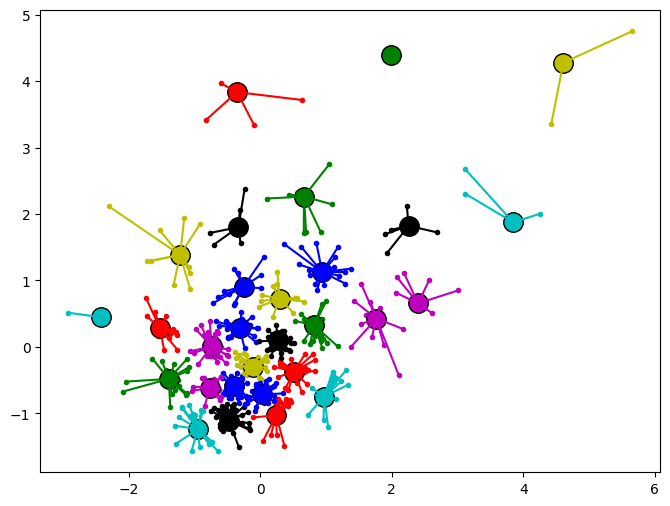

In [29]:
no_clusters = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % no_clusters)
# Plot exemplars

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

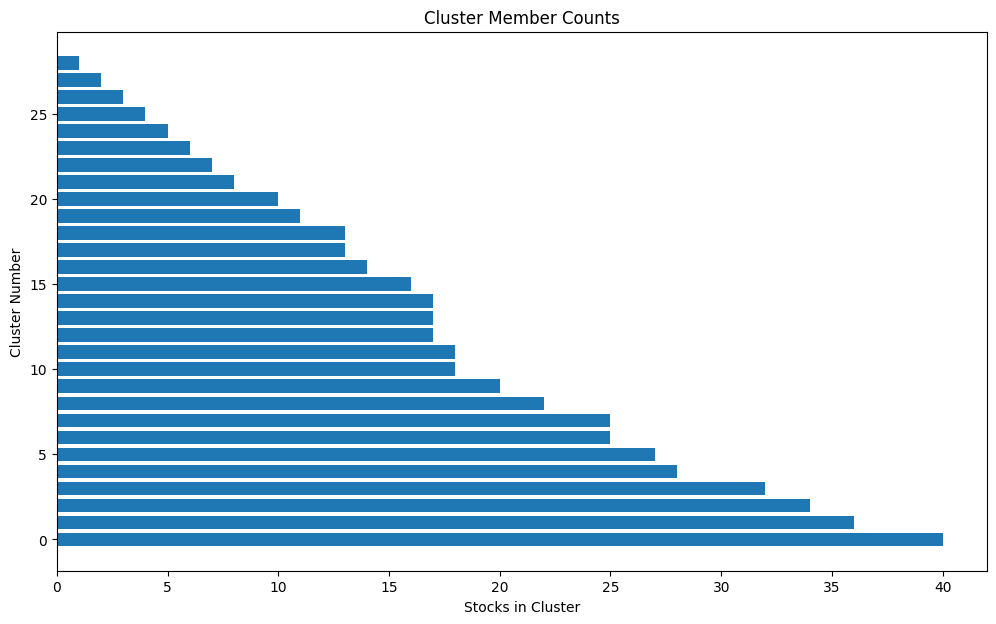

In [30]:
# show number of stocks in each cluster
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(12,7))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # cluster labels, y axis
    clustered_series_ap.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

<a id='5.4'></a>
## 5.4. Cluster Evaluation

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

In [31]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.35057302321948336
hc 0.3370118978233046
ap 0.3550081567987897


Given the affinity propagation performs the best, we go ahead with the affinity propagation and use 27 clusters as specified by this clustering method

### Visualising the return within a cluster

The understand the intuition behind clustering, let us visualize the results of the clusters.

In [32]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

In [33]:
# get the number of stocks in each cluster
counts = clustered_series_ap.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[24, 19, 3, 16, 6, 13, 25, 8, 5, 9, 4, 14, 17, 12, 1, 23, 22, 21, 10, 18]

In [34]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 28
Pairs to evaluate: 10964


In [35]:
# plot a handful of the smallest clusters
plt.figure(figsize=(12,7))
cluster_vis_list[0:min(len(cluster_vis_list), 4)]

[24, 19, 3, 16]

<Figure size 1200x700 with 0 Axes>

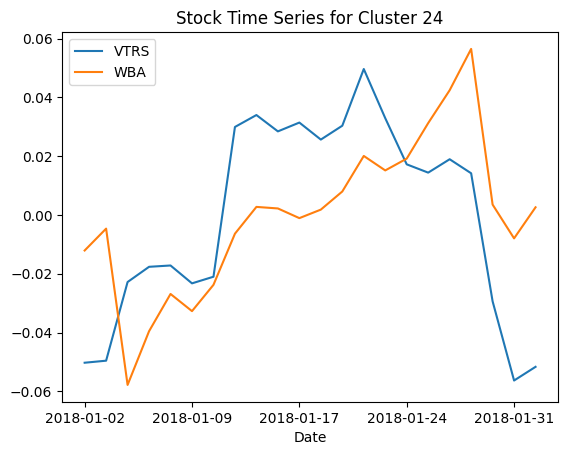

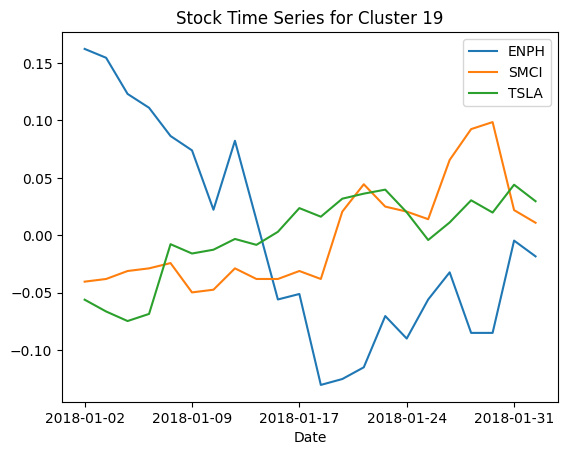

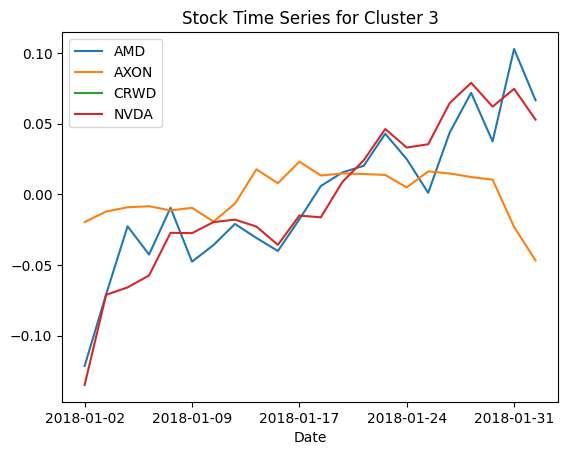

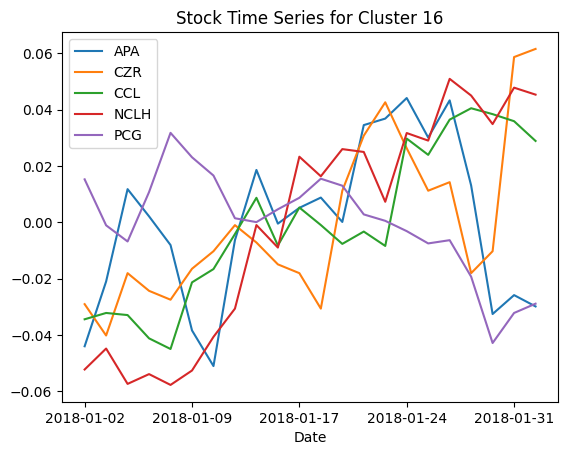

In [36]:
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(dataset.loc[:"2018-02-01", tickers].mean())
    data = np.log(dataset.loc[:"2018-02-01", tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)
plt.show()

Looking at the charts above, across all the clusters with small number of stocks, we
see similar movement of the stocks under different clusters, which corroborates the
effectiveness of the clustering technique.

<a id='6'></a>
# 6. Pairs Selection

<a id='6.1'></a>
## 6.1. Cointegration and Pair Selection Function

In [46]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            # Check for and replace infinite values with NaN
            S1 = S1.replace([np.inf, -np.inf], np.nan)
            S2 = S2.replace([np.inf, -np.inf], np.nan)

            # Drop rows with NaN values for coint function
            index = ~np.isnan(S1) & ~np.isnan(S2)
            S1, S2 = S1[index], S2[index]


            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [47]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        dataset[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [48]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [49]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 399
In those pairs, there are 297 unique tickers.


In [50]:
pairs

[('ABT', 'AWK'),
 ('ABT', 'HON'),
 ('ABT', 'IEX'),
 ('LNT', 'CMS'),
 ('LNT', 'JKHY'),
 ('LNT', 'PM'),
 ('LNT', 'PG'),
 ('LNT', 'DGX'),
 ('AEE', 'EVRG'),
 ('AEE', 'JKHY'),
 ('AEE', 'DGX'),
 ('AEP', 'JKHY'),
 ('AEP', 'PM'),
 ('AEP', 'SRE'),
 ('AMGN', 'LMT'),
 ('ATO', 'IBM'),
 ('ATO', 'PPL'),
 ('CHD', 'ITW'),
 ('CHD', 'PG'),
 ('CHD', 'ROP'),
 ('CMS', 'JKHY'),
 ('CMS', 'PM'),
 ('CMS', 'PG'),
 ('DTE', 'DUK'),
 ('DTE', 'PM'),
 ('DTE', 'PG'),
 ('DTE', 'PSA'),
 ('DUK', 'PM'),
 ('DUK', 'PSA'),
 ('DUK', 'DGX'),
 ('EVRG', 'JKHY'),
 ('EVRG', 'K'),
 ('EVRG', 'PM'),
 ('EVRG', 'PSA'),
 ('EXPD', 'IEX'),
 ('EXPD', 'DGX'),
 ('EXPD', 'YUM'),
 ('HON', 'IEX'),
 ('HON', 'DGX'),
 ('IEX', 'DGX'),
 ('IEX', 'YUM'),
 ('ITW', 'MCD'),
 ('ITW', 'PG'),
 ('ITW', 'DGX'),
 ('ITW', 'ROP'),
 ('JKHY', 'K'),
 ('JKHY', 'LMT'),
 ('JKHY', 'MCD'),
 ('JKHY', 'PM'),
 ('JKHY', 'PG'),
 ('JKHY', 'PSA'),
 ('JKHY', 'DGX'),
 ('JKHY', 'SRE'),
 ('JKHY', 'WEC'),
 ('JKHY', 'XEL'),
 ('LMT', 'PM'),
 ('LMT', 'SRE'),
 ('MKC', 'XEL'),
 ('MCD',

<a id='6.2'></a>
## 6.2. Pair Visualization

In [51]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

In [52]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

In [53]:
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

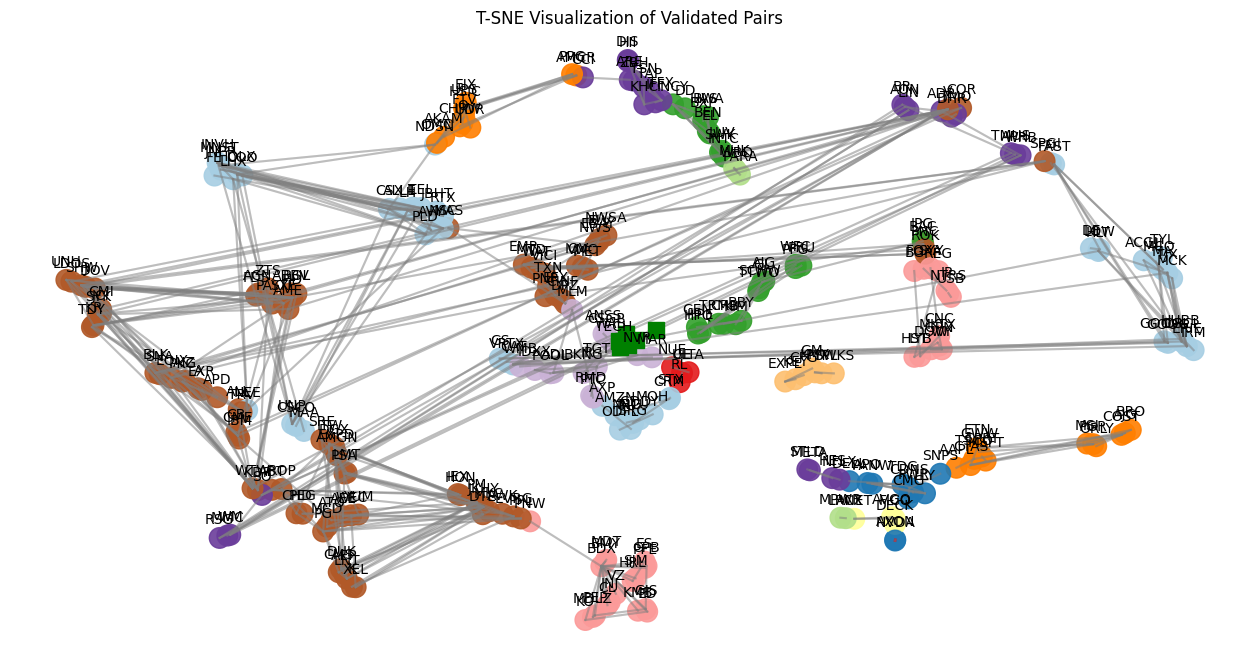

In [71]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    #print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    #print(ticker1, loc1)

    ticker2 = pair[1]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]

    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');

# zip joins x and y coordinates in pairs
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)


In [68]:
# Pairs containing NVDA
print("Pairs containing NVDA:")
for pair in pairs:
    if 'NVDA' in pair:
        print(pair)

Pairs containing NVDA:
('AXON', 'NVDA')


**Conclusion**

The clustering techniques do not directly help in stock trend prediction. However,
they can be effectively used in portfolio construction for finding the right pairs,
which eventually help in risk mitigation and one can achieve superior risk adjusted
returns.

We showed the approaches to finding the appropriate number of clusters in k-means
and built a hierarchy graph in hierarchical clustering. A next step from this case study
would be to explore and backtest various long/short trading strategies with pairs of
stocks from the groupings of stocks.

Clustering can effectively be used for dividing stocks into groups with “similar characteristics” for many other kinds of trading strategies and can help in portfolio construction to ensure we choose a universe of stocks with sufficient diversification
between them.

Visualization with PCA

In [72]:
from sklearn.decomposition import PCA

In [73]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pairs)

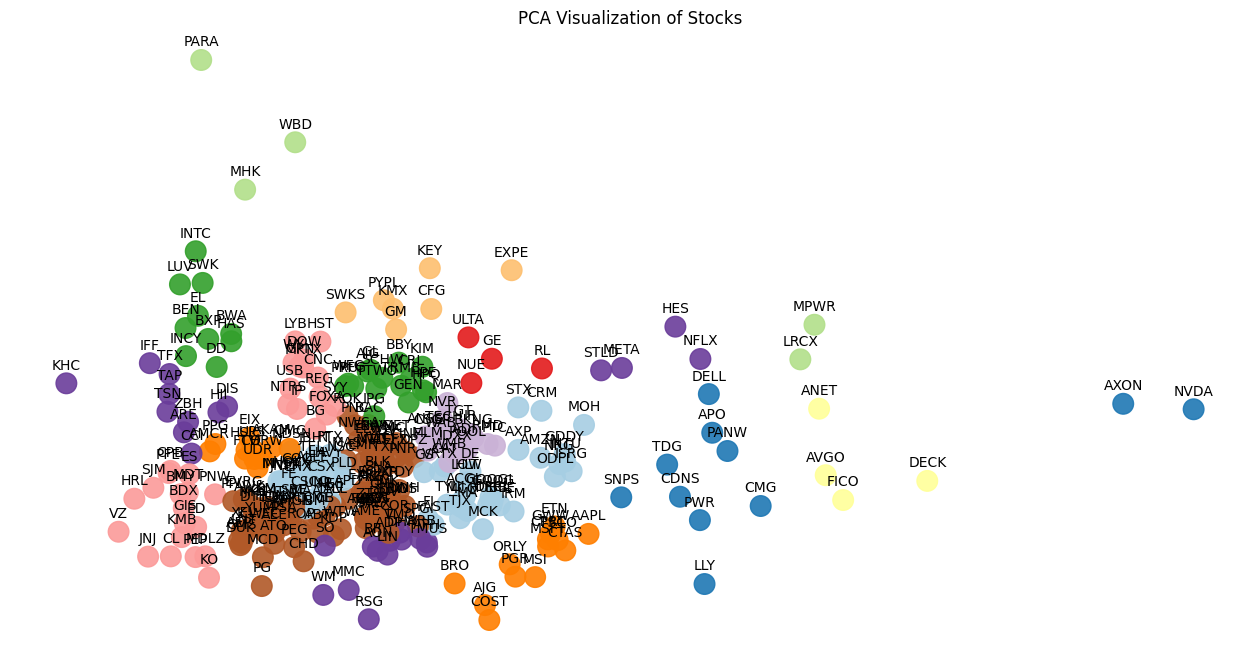

In [74]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')

plt.scatter(X_pca[:, 0], X_pca[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)

plt.title('PCA Visualization of Stocks');

for x,y,name in zip(X_pca[:,0],X_pca[:,1],X_pairs.index):
       label = name
       plt.annotate(label,
              (x,y),
              textcoords="offset points",
              xytext=(0,10),
              ha='center')
plt.show()